# Heat pipe modeling

This notebook embedd a dynamic lumped model of heat pipes.

## Goal

Solve the temperature transient of an heat pipe with different fluids. Plot the reults.

## Approach

1) read the thermophysical properties of the fluid and other parameters
2) Fitting data point as function of temperature
3) read heat pipe geometry file
4) read the initial condition file
5) Solve the system dynamic
6) plot the results

## Required tools

Pandas for reading files 

numpy for curve fitting (polynomial)

scipy for ode integration

matplotlib for visualisation

### Step 1: Import data with pandas

In [1]:
import pandas as pd

In [2]:
filename_fluid = "water.xlsx" #Change here the fluid

thermophys_data = pd.ExcelFile(filename_fluid)
print(type(thermophys_data))

thermophys_data = thermophys_data.parse("Sheet1") #overwrite to get a DataFrame
print(type(thermophys_data))

thermophys_data

<class 'pandas.io.excel._base.ExcelFile'>
<class 'pandas.core.frame.DataFrame'>


,Temperature (K),Saturation pressure (Pa),Latent heat (kJ/kg),Liquid density (kg/m3),Vapor density (kg/m3),Liquid viscosity (N-s/m2),Vapor viscosity (N-s/m2),Liquid thermal conductivity (W/m-K),Vapor thermal conductivity (W/m-K),Liquid surface tension (N/m),Liquid specific heat (kJ/kg-K),Vapor specific heat (kJ/kg-K)
0,308.00,2336.8,2453.8,999.00,0.01729,0.001002,0.000009,0.602,0.0188,0.07288,4.182,1.874
1,313.15,7374.9,2406.5,993.05,0.05110,0.000651,0.000010,0.630,0.0201,0.06948,4.179,1.894
2,333.15,19919.0,2358.4,983.28,0.13020,0.000463,0.000010,0.653,0.0216,0.06607,4.185,1.924
3,353.15,47359.0,2308.9,971.82,0.29320,0.000351,0.000011,0.669,0.0231,0.06269,4.197,1.969
4,373.15,101325.0,2251.2,958.77,0.59740,0.000279,0.000012,0.680,0.0248,0.05891,4.216,2.034
5,393.15,198540.0,2202.9,943.39,1.12100,0.000230,0.000013,0.685,0.0267,0.05496,4.245,2.124
6,413.15,361360.0,2144.9,925.93,1.96560,0.000195,0.000013,0.687,0.0288,0.05079,4.285,2.245
7,433.15,618040.0,2082.2,907.44,3.25890,0.000169,0.000014,0.684,0.0313,0.04651,4.339,2.406
8,453.15,1002700.0,2014.0,887.31,5.15970,0.000149,0.000015,0.676,0.0341,0.04219,4.408,2.615
9,473.15,1555100.0,1939.0,865.05,7.86530,0.000134,0.000016,0.664,0.0375,0.03777,4.497,2.883


In [3]:
filename_hp = "heat_pipe_specs.xlsx" #heat pipe data specification

hp_data = pd.ExcelFile(filename_hp)
print(type(hp_data))

hp_data = hp_data.parse("Sheet1") #overwrite to get a DataFrame
print(type(hp_data))

hp_data

<class 'pandas.io.excel._base.ExcelFile'>
<class 'pandas.core.frame.DataFrame'>


,evaporator length (m),adiabatic length (m),condenser length (m),pipe external diameter (m),pipe internal diameter (m),wick internal diameter (m),wick permeability,wick porosity,wick effective porosity,cavity radius (m),wick heat capacity (J/kg-K),wick thermal conductivity (W/m-K),wick density (kg/m3),pipe heat capacity (J/kg-K),pipe thermal conductivity (W/m-K),pipe density (kg/m3)
0,0.6,0.09,0.2,0.0191,0.0173,0.01655,1.500000e-09,0.9,0.5,0.000022,380,390,8920,380,390,8920


In [4]:
filename_par = "parameters.xlsx" #thermal parameters specification

parameters_data = pd.ExcelFile(filename_par)
print(type(hp_data))

parameters_data = parameters_data.parse("Sheet1") #overwrite to get a DataFrame
print(type(parameters_data))

parameters_data

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,input power (W),htc (W/m2-K),cooling fluid temperature (K)
0,443,140,284


## Fit of fluid thermophysical properties

In [5]:
import numpy as np
from numpy.polynomial import Polynomial
from scipy import interpolate


#extract data from DataFrame to arrays

temperature_for_fit = thermophys_data["Temperature (K)"] #get the dataframe slice
temperature_for_fit = temperature_for_fit.values #get only the values
temperature_for_fit = temperature_for_fit.tolist() #convert to list
temperature_for_fit = np.array([temperature_for_fit[0]-200] +  temperature_for_fit + [temperature_for_fit[-1]+200]) #extend and convert to an array


#poly_deg = 4 #degree of the polynomial


#Fit all the required parameters

#pressure_for_fit = thermophys_data["Saturation pressure (Pa)"].values
#p_sat = Polynomial.fit(temperature_for_fit, pressure_for_fit,poly_deg) #note that np.polyfit is now legacy
p_sat_for_fit = thermophys_data["Saturation pressure (Pa)"].values
p_sat_for_fit = p_sat_for_fit.tolist() #convert in list
p_sat_for_fit = np.array([p_sat_for_fit[0]] + p_sat_for_fit + [p_sat_for_fit[-1]]) #duplicate first and last elements

p_sat = interpolate.interp1d(temperature_for_fit, p_sat_for_fit,kind = "linear") 


latentheat_for_fit = thermophys_data["Latent heat (kJ/kg)"].values
latentheat_for_fit = latentheat_for_fit.tolist() #convert in list
latentheat_for_fit = np.array([latentheat_for_fit[0]] + latentheat_for_fit + [latentheat_for_fit[-1]])*1e3 #duplicate first and last elements


#hlv_sat = Polynomial.fit(temperature_for_fit, latentheat_for_fit,poly_deg) 
hlv_sat = interpolate.interp1d(temperature_for_fit, latentheat_for_fit,kind = "linear") 

liquiddensity_for_fit = thermophys_data["Liquid density (kg/m3)"].values.tolist()
liquiddensity_for_fit = np.array([liquiddensity_for_fit[0]] + liquiddensity_for_fit + [liquiddensity_for_fit[-1]])
#rhol_sat = Polynomial.fit(temperature_for_fit, liquiddensity_for_fit,poly_deg) 
rhol_sat =  interpolate.interp1d(temperature_for_fit, liquiddensity_for_fit,kind = "linear") 

vapordensity_for_fit = thermophys_data["Vapor density (kg/m3)"].values.tolist()
vapordensity_for_fit = np.array([vapordensity_for_fit[0]] + vapordensity_for_fit + [vapordensity_for_fit[-1]])
#rhov_sat = Polynomial.fit(temperature_for_fit, vapordensity_for_fit,poly_deg) 
rhov_sat = interpolate.interp1d(temperature_for_fit, vapordensity_for_fit,kind= "linear") 

liquidviscosity_for_fit = thermophys_data["Liquid viscosity (N-s/m2)"].values.tolist()
liquidviscosity_for_fit = np.array([liquidviscosity_for_fit[0]] + liquidviscosity_for_fit + [liquidviscosity_for_fit[-1]])
#mul_sat = Polynomial.fit(temperature_for_fit, liquidviscosity_for_fit,poly_deg) 
mul_sat = interpolate.interp1d(temperature_for_fit, liquidviscosity_for_fit,kind = "linear") 

vaporviscosity_for_fit = thermophys_data["Vapor viscosity (N-s/m2)"].values.tolist()
vaporviscosity_for_fit = np.array([vaporviscosity_for_fit[0]] + vaporviscosity_for_fit + [vaporviscosity_for_fit[-1]])
#muv_sat = Polynomial.fit(temperature_for_fit, vaporviscosity_for_fit,poly_deg) 
muv_sat = interpolate.interp1d(temperature_for_fit, vaporviscosity_for_fit,kind="linear") 

liquidconductivity_for_fit = thermophys_data["Liquid thermal conductivity (W/m-K)"].values.tolist()
liquidconductivity_for_fit = np.array([liquidconductivity_for_fit[0]] + liquidconductivity_for_fit + [liquidconductivity_for_fit[-1]])
#kl_sat = Polynomial.fit(temperature_for_fit, liquidconductivity_for_fit,poly_deg) 
kl_sat = interpolate.interp1d(temperature_for_fit, liquidconductivity_for_fit,kind="linear")

liquidtension_for_fit = thermophys_data["Liquid surface tension (N/m)"].values.tolist()
liquidtension_for_fit = np.array([liquidtension_for_fit[0]] + liquidtension_for_fit + [liquidtension_for_fit[-1]])
#sigma_sat = Polynomial.fit(temperature_for_fit, liquidtension_for_fit,poly_deg) 
sigma_sat = interpolate.interp1d(temperature_for_fit, liquidtension_for_fit,kind = "linear")

liquidcapacity_for_fit = (thermophys_data["Liquid specific heat (kJ/kg-K)"].values*1e3).tolist()
liquidcapacity_for_fit = np.array([liquidcapacity_for_fit[0]] + liquidcapacity_for_fit + [liquidcapacity_for_fit[-1]])
#cl_sat = Polynomial.fit(temperature_for_fit, liquidcapacity_for_fit,poly_deg) 
cl_sat = interpolate.interp1d(temperature_for_fit, liquidcapacity_for_fit,kind = "linear") 


temperature_for_plot = np.linspace(temperature_for_fit[0],temperature_for_fit[-1], 40)


### Polt the interpolation function to see the correctness

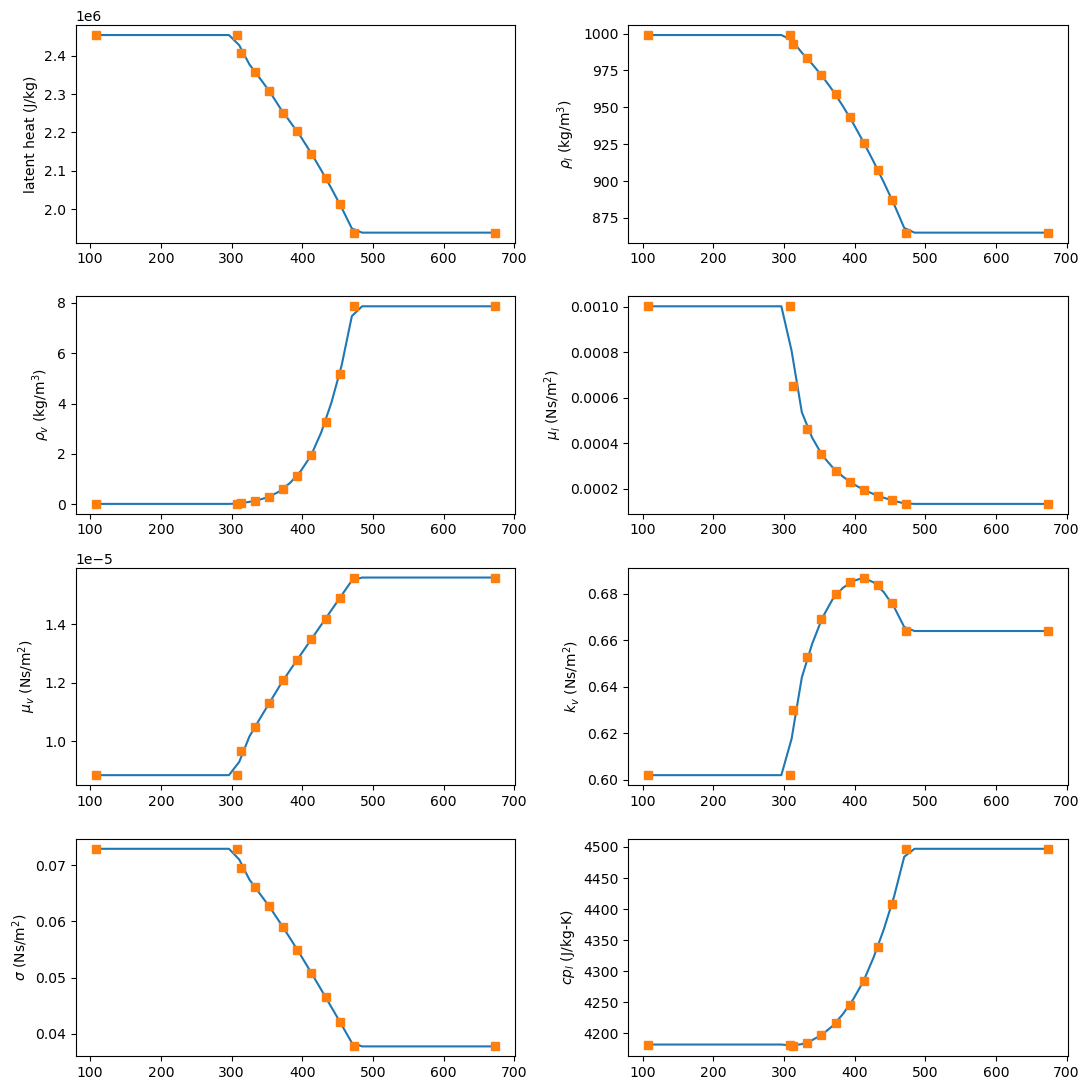

In [6]:
import matplotlib.pyplot as plt


#create subplots

fig, axs = plt.subplots(4,2, figsize = (11,11))


axs[0,0].plot(temperature_for_plot,hlv_sat(temperature_for_plot))
axs[0,0].plot(temperature_for_fit,latentheat_for_fit, linestyle = "none", marker = "s")
axs[0,0].set_ylabel("latent heat (J/kg)")

axs[0,1].plot(temperature_for_plot,rhol_sat(temperature_for_plot))
axs[0,1].plot(temperature_for_fit,liquiddensity_for_fit, linestyle = "none", marker = "s")
axs[0,1].set_ylabel("$\u03C1_l$ (kg/m$^3$)")

axs[1,0].plot(temperature_for_plot,rhov_sat(temperature_for_plot))
axs[1,0].plot(temperature_for_fit,vapordensity_for_fit, linestyle = "none", marker = "s")
axs[1,0].set_ylabel("$\u03C1_v$ (kg/m$^3$)")

axs[1,1].plot(temperature_for_plot,mul_sat(temperature_for_plot))
axs[1,1].plot(temperature_for_fit,liquidviscosity_for_fit, linestyle = "none", marker = "s")
axs[1,1].set_ylabel("$\mu_l$ (Ns/m$^2$)")

axs[2,0].plot(temperature_for_plot,muv_sat(temperature_for_plot))
axs[2,0].plot(temperature_for_fit,vaporviscosity_for_fit, linestyle = "none", marker = "s")
axs[2,0].set_ylabel("$\mu_v$ (Ns/m$^2$)")

axs[2,1].plot(temperature_for_plot,kl_sat(temperature_for_plot))
axs[2,1].plot(temperature_for_fit,liquidconductivity_for_fit, linestyle = "none", marker = "s")
axs[2,1].set_ylabel("$k_v$ (Ns/m$^2$)")

axs[3,0].plot(temperature_for_plot,sigma_sat(temperature_for_plot))
axs[3,0].plot(temperature_for_fit,liquidtension_for_fit, linestyle = "none", marker = "s")
axs[3,0].set_ylabel("$\sigma$ (Ns/m$^2$)")

axs[3,1].plot(temperature_for_plot,cl_sat(temperature_for_plot))
axs[3,1].plot(temperature_for_fit,liquidcapacity_for_fit, linestyle = "none", marker = "s")
axs[3,1].set_ylabel("$cp_l$ (J/kg-K)")

axs[3,0].ticklabel_format(style="sci", axis = "y")
axs[3,1].ticklabel_format(style="sci", axis = "y")

axs[2,0].ticklabel_format(style="sci", axis = "y")
axs[2,1].ticklabel_format(style="sci", axis = "y")

axs[1,0].ticklabel_format(style="sci", axis = "y")
axs[1,1].ticklabel_format(style="sci", axis = "y")

axs[0,0].ticklabel_format(style="sci", axis = "y")
axs[0,1].ticklabel_format(style="sci", axis = "y")

fig.tight_layout() #djust space between subplots, minimize overlap

## Definition of some constants and variables

In [7]:
R = 8.314/(18e-3) #perfect gas reduced constant
gamma = 1.33      #cp/cv


#SOLID PROPERTIES
rhop = float(hp_data["pipe density (kg/m3)"].values)    #kg/m3
kp = float(hp_data["pipe thermal conductivity (W/m-K)"].values)  #W/mK
cp = float(hp_data["pipe heat capacity (J/kg-K)"].values)       #J/kg/K

rhow0 = float(hp_data["wick density (kg/m3)"].values)     #kg/m3
kw0 = float(hp_data["wick thermal conductivity (W/m-K)"].values)     #kg/m3
cp0 = float(hp_data["wick heat capacity (J/kg-K)"].values)     #kg/m3




#HP SPECS
dep = float(hp_data["pipe external diameter (m)"].values)
dip = float(hp_data["pipe internal diameter (m)"].values)
diw = float(hp_data["wick internal diameter (m)"].values)

print("outer pipe diameter (m): ", dep)
print("inner pipe diameter (m): ", dip)
print("inner wick diameter (m): ", diw)


Leva = float(hp_data["evaporator length (m)"].values)
La = float(hp_data["adiabatic length (m)"].values)
Lcond = float(hp_data["condenser length (m)"].values)

epsilon = float(hp_data["wick porosity"].values)
epsilon_eff = float(hp_data["wick effective porosity"].values)     #kg/m3
rc = float(hp_data["cavity radius (m)"].values)
K = float(hp_data["wick permeability"].values)

#compute cooling area in condenser
Af = Lcond*2*np.pi*(dep/2)+np.pi*(dep/2)**2  #condenser outer surface (cooling)
hf = float(parameters_data["htc (W/m2-K)"].values)


#VOLUMES
Vc = Lcond*np.pi*diw**2/4
Ve = Leva*np.pi*diw**2/4

#effective length
Leff = Leva/2 + La + Lcond/2

#INPUT POWER
Qin =float(parameters_data["input power (W)"].values)

#COOLING PART (assumed water)
Tf = float(parameters_data["cooling fluid temperature (K)"].values)
#muf = float(thermophys_cooler_data["Liquid viscosity (N-s/m2)"].values[0])
#kf = float(thermophys_cooler_data["Liquid thermal conductivity (W/m-K)"].values[0])
#cf = float(thermophys_cooler_data["Liquid specific heat (kJ/kg-K)"].values[0]*1e3)








outer pipe diameter (m):  0.0191
inner pipe diameter (m):  0.0173
inner wick diameter (m):  0.01655


## Initial conditions

In [8]:

T0 = 296

#INITIAL CONDITIONS
Mle_0 = rhol_sat(T0)*epsilon*Leva*np.pi*(dip**2 - diw**2)/4 #liquid mass in evaporator
Mlc_0 = rhol_sat(T0)*epsilon*Lcond*np.pi*(dip**2 - diw**2)/4 #liquid mass in adiabatic region
pve0 = float(p_sat(T0))#T0*R*rhov_sat(T0)#0.023360e5 pressure in evaporator
pvc0 = float(p_sat(T0))#T0*R*rhov_sat(T0)#0.023360e5 pressure in condenser
#T0*R*rhova
y0 = [T0,T0,T0,T0,T0,T0,0,pve0,pvc0,T0,T0,Mle_0,Mlc_0]

#float conversion is required otherwise the list is a mix between scalars and arrays

pvc0

2336.8

## Creation of the numerical model


In [9]:
from scipy.integrate import solve_ivp





def hp_model1(t,y):
    
    
    #y vector
    Tpe = y[0] #pipe evaporator temperature
    Tpc = y[1] #pipe condenser temperature
    Twe = y[2] #wick evaporator temperature
    Twc = y[3] #wick condenser temperature
    Tpa = y[4] #pipe adiabatic temperature
    Twa = y[5] #wick adiabatic temperature
    mdotv = y[6] #vapor mass flow rate
    Pve = y[7] #vapor pressure evaporator region
    Pvc = y[8] #vapor pressure condenser region
    Tve = y[9] #vapor evaporator temperature
    Tvc = y[10] #vapor condenser temperature
    Mle = y[11] #liquid mass in evaporator
    Mlc = y[12] #liquid mass in condenser

    
    
    #wrapped screen wick effective thermal conductivity
    
    kle = kl_sat(Twe)
    klc = kl_sat(Twc)
    kla = kl_sat(Twa)
    
    
    kwe = kle*((kle+kw0) - (1-epsilon_eff)*(kle-kw0))/((kle+kw0)+(1-epsilon_eff)*(kle-kw0))
    kwc = klc*((klc+kw0) - (1-epsilon_eff)*(klc-kw0))/((klc+kw0)+(1-epsilon_eff)*(klc-kw0))
    kwa = klc*((kla+kw0) - (1-epsilon_eff)*(kla-kw0))/((kla+kw0)+(1-epsilon_eff)*(kla-kw0))
    
    
    #thermophysical prop in the three regions
    mule = mul_sat(Twe)
    mula = mul_sat(Twa)
    muva = (muv_sat(Tve) + muv_sat(Tvc))/2
    
    
    
    rhole = rhol_sat(Twe)
    rhola = rhol_sat(Twa)
    rholc = rhol_sat(Twc)
    rhova = (rhov_sat(Tve) + rhov_sat(Tvc))/2
    
    
    
    #THERMAL RESISTANCES
    #radial resistance
    R1pe = np.log(dep/(dip+dep)*2)/(2*np.pi*kp*Leva) #(dip+dep)/2 average diameter
    R2pe = np.log((dip+dep)/2/dip)/(2*np.pi*kp*Leva)
    R1we = np.log(dip/(diw+dip)*2)/(2*np.pi*kwe*Leva)
    R2we = np.log((diw+dip)/2/diw)/(2*np.pi*kwe*Leva)
    R1pc = np.log(dep/(dip+dep)*2)/(2*np.pi*kp*Lcond)
    R2pc = np.log((diw+dip)/2/diw)/(2*np.pi*kp*Lcond)
    R1wc = np.log(dip/(diw+dip)*2)/(2*np.pi*kwc*Lcond)#np.log(dep/(dip+dep)*2)/(2*np.pi*kwc*Lcond)
    R2wc = np.log((diw+dip)/2/diw)/(2*np.pi*kwc*Lcond)#np.log((diw+dip)/2/diw)/(2*np.pi*kwc*Lcond)
    
    #R2wa = np.log((diw+dip)/2/diw)/(2*np.pi*kwa*La)
    #R2wa = np.log((diw+dip)/2/diw)/(2*np.pi*kp*La)
    Rf = 1/hf/Af #external cooling resistance

    #axial resistances
    #which is the length?
    R1pa = 2*(Leva+La)/2/kp/(np.pi*(dep**2-dip**2)/4)#np.log(dep/(dip+dep)*2)/(2*np.pi*kp*La)
    R2pa = 2*(La+Lcond)/2/kp/(np.pi*(dep**2-dip**2)/4)#np.log((dip+dep)/2/dip)/(2*np.pi*kp*La)
    R1wa = 2*(Leva+La)/2/kwa/(np.pi*(dip**2-diw**2)/4)#np.log(dip/(diw+dip)*2)/(2*np.pi*kw*La)
    R2wa = 2*(La+Lcond)/2/kwa/(np.pi*(dip**2-diw**2)/4)#np.log((diw+dip)/2/diw)/(2*np.pi*kw*La)
    
    
    
    #specific heat in evaporator, adiabatic region, condenser
    cle = cl_sat(Twe) 
    clc = cl_sat(Twc) 
    cla = cl_sat(Twa) 

    
    #Thermal capacities
    Cpe  = rhop*cp*(Leva*np.pi*(dep**2-dip**2)/4)
    Cwe  = ((rhop*cp)*(1-epsilon)+(rhole*cle)*epsilon)*(Leva*np.pi*(dip**2-diw**2)/4)
    Cpa  = rhop*cp*(La*np.pi*(dep**2-dip**2)/4)
    Cwa  = ((rhop*cp)*(1-epsilon)+(rhola*cla)*epsilon)*(La*np.pi*(dip**2-diw**2)/4)
    Cpc  = rhop*cp*(Lcond*np.pi*(dep**2-dip**2)/4)
    Cwc  = ((rhop*cp)*(1-epsilon)+(rholc*clc)*epsilon)*(Lcond*np.pi*(dip**2-diw**2)/4)

    

    
    #vapor inductance and resistances
    Lva  = Leff/(np.pi*diw**2/4)
    Rle  = mule*Leva/(K*rhole*epsilon*np.pi*(dip**2-diw**2)/4)
    Rla  = mula/(K*rhola*epsilon*np.pi*(dip**2-diw**2)/4)
    Rva  = 8*muva*Leff/(rhova*np.pi*(diw/2)**4) 
    
    #thermophysical prop in ev, ad, cond
    hlv = hlv_sat(Twe)
    
    sigmaa = sigma_sat(Twa)
    sigmae = sigma_sat(Twe)
    sigmac = sigma_sat(Twc)
    sigma = np.mean([sigmaa,sigmae,sigmac])
    
    #UPDATE VAPOR CAPACITIES
    Cvc  = Vc/gamma/R/Tvc
    Cve  = Ve/gamma/R/Tve


    #Qin = -(Tpe-Teva)/R1pe
    Qout = (Tpc-Tf)/(R1pc+Rf)

    
    #if Tpe >290:
    #    Tpe = 290
    
    if (Mle <= Mle_0) and (Mle > 0): #Mle_0 should be the mass with full filled wick
        f = -(Mle/Mle_0)+1
        f_masse = 1
    elif Mle>Mle_0: 
        f = (Pve-Pvc)/(2*sigma/rc)
        f_masse = 1
    else: 
        f = 0
        f_masse = 0
    
    
    #f = 0
    

    #differential equations
    dydt = [
        Qin/Cpe - (Tpe - Tpa)/R1pa/Cpe - (Tpe-Twe)/(R2pe+R1we)/Cpe,
        -(Tpc-Tpa)/R2pa/Cpc - (Tpc-Twc)/(R2pc+R1wc)/Cpc - Qout/Cpc,
        -(Twe -Twa)/R2wa/Cwe + (Tpe-Twe)/(R2pe+R1we)/Cwe - (Twe-Tve)/R2we/Cwe,
        -(Twc-Twa)/R2wa/Cwc + (Tpc-Twc)/(R2pc+R1wc)/Cwc - (Twc-Tvc)/R2wc/Cwc,
        -(Tpa-Tpe)/R1pa/Cpa - (Tpa-Tpc)/R2pa/Cpa,
        -(Twa-Twe)/R1wa/Cwa - (Twa-Twc)/R2wa/Cwa,
        Rva/Lva*mdotv + Pve/Lva - Pvc/Lva,
        f_masse*(Twe-Tve)/Cve/R2we/hlv - mdotv/Cve,
        mdotv/Cvc + (Twc-Tvc)/R2wc/hlv/Cvc,
        (gamma-1)/gamma*Tve/Pve*(f_masse*(Twe-Tve)/Cve/R2we/hlv - mdotv/Cve), #check fmasse
        (gamma-1)/gamma*Tvc/Pvc*(mdotv/Cvc + (Twc-Tvc)/R2wc/hlv/Cvc),
        #+ 2*sigma*f/Rva/rc -f_masse*(Twe-Tve)/R2we/hlv, #check fmasse
        + (Pvc-Pve)/Rva + 2*sigma*f/Rva/rc -f_masse*(Twe-Tve)/R2we/hlv, #check fmasse
        #- 2*sigma*f/Rva/rc -(Twc-Tvc)/R2wc/hlv]
        - (Pvc-Pve)/Rva - 2*sigma*f/Rva/rc -(Twc-Tvc)/R2wc/hlv]
        
        
    
    return dydt

    





## Solve the model with different solvers

Python allow for different solvers: 
1) RK23:Explicit Runge-Kutta method of order 3(2)
2) RK45:Explicit Runge-Kutta method of order 5(4)
3) DOP853:Explicit Runge-Kutta method of order 8
4) Radau: Implicit Runge-Kutta method of the Radau IIA family of order 5
5) BDF: Implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation
6) LSODA: Adams/BDF method with automatic stiffness detection and switching

BDF and Radau will be compared in terms of results and computational time, to do that, time package is required.

In [10]:
import time #required to measure the simulation time

In [11]:
#TIME SPAN
tt = [0,500]

#SOLVE THE MODEL - Radau
st = time.time()

solution = solve_ivp(hp_model1,t_span = tt, y0 = y0 ,method='Radau')
et = time.time()

print("simulation time Radau:", round(et-st,4))

#SAVE THE SOLUTION - Radau
t_rad = solution.t
y_rad = solution.y



#SOLVE THE MODEL - BDF
st = time.time()
solution = solve_ivp(hp_model1,t_span = tt, y0 = y0 ,method='BDF')
et = time.time()

print("simulation time BDF:", round(et-st,4))

#SAVE THE SOLUTION - BDF
t_bdf = solution.t
y_bdf = solution.y

#Note: explicit RK method are not adopted since are pretty slow for this model, stiff problem


ValueError: A value in x_new is below the interpolation range.

## Compare the solvers by the results

In [ ]:
elgenk_times = [0,66,130,225,500]
elgenk_wallTemp = np.array([296,316,330,338,342])

In [ ]:
fig, axs = plt.subplots(1,2)

axs[0].plot(elgenk_times, elgenk_wallTemp, linestyle ="None", marker ="s")
axs[0].plot(t_rad,y_rad[0],label="Tpe")
axs[0].plot(t_rad,y_rad[1],label="Tpc")
axs[0].plot(t_rad,y_rad[2],label="Twe")
axs[0].plot(t_rad,y_rad[3],label="Twc")
axs[0].plot(t_rad,y_rad[4],label="Tpa")
axs[0].plot(t_rad,y_rad[5],label="Twa")
axs[0].grid(linestyle=":")
axs[0].set_title("Radau solver")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Temperature (K)")

axs[1].plot(t_bdf,y_bdf[0],label="Tpe")
axs[1].plot(t_bdf,y_bdf[1],label="Tpc")
axs[1].plot(t_bdf,y_bdf[2],label="Twe")
axs[1].plot(t_bdf,y_bdf[3],label="Twc")
axs[1].plot(t_bdf,y_bdf[4],label="Tpa")
axs[1].plot(t_bdf,y_bdf[5],label="Twa")
axs[1].grid(linestyle=":")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")


axs[0].legend(loc='upper center')
axs[1].legend(loc='upper center')

In [ ]:
fig, axs = plt.subplots(1,2)

#axs[0].plot(t_rad,y_rad[7], label="Pve")
#axs[0].plot(t_rad,y_rad[8], label="Pvc")
#axs[0].set_title("Radau solver")
#axs[0].set_xlabel("Time (s)")
#axs[0].set_ylabel("Pressure (Pa)")

axs[1].plot(t_bdf,y_bdf[7], label="Pve")
axs[1].plot(t_bdf,y_bdf[8], label="Pvc")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")

axs[0].legend()
axs[1].legend()

plt.tight_layout()

### plot liquid mass in wick

In [ ]:
fig, axs = plt.subplots(1,2)

axs[0].plot(t_rad,y_rad[11], label="Mle")
axs[0].plot(t_rad,y_rad[12], label="Mlc")
axs[0].set_title("Radau solver")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Liquid mass (kg)")

axs[1].plot(t_bdf,y_bdf[11], label="Mle")
axs[1].plot(t_bdf,y_bdf[12], label="Mlc")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")

axs[0].legend()
axs[1].legend()

plt.tight_layout()


The two solver provide quite different results in terms of the mass in the wick, both are wrong from a physical point of view, since mass can not be negative. However, Radau preserves a simmetry between the condenser and the evaporator, that is correct mathematically. BDF do not.

Comparing the computational time considering the same amount of timesteps:

In [ ]:
#TIME SPAN
tt = [0,500]
#TIMESTEPS
Nsteps = 1000
tsteps = np.linspace(tt[0],tt[-1],Nsteps)

##SOLVE THE MODEL - Radau
#st = time.time()
#solution = solve_ivp(hp_model1,t_span = tt, t_eval  = tsteps, y0 = y0 ,method='Radau')
#et = time.time()

#print("simulation time Radau:", round(et-st,4))

#SAVE THE SOLUTION - Radau
#t_rad = solution.t
#y_rad = solution.y



#SOLVE THE MODEL - BDF
st = time.time()
solution = solve_ivp(hp_model1,t_span = tt, t_eval  = tsteps, y0 = y0 ,method='BDF')
et = time.time()

print("simulation time BDF:", round(et-st,4))

#SAVE THE SOLUTION - BDF
t_bdf = solution.t
y_bdf = solution.y

#Note: explicit RK method are not adopted since are pretty slow for this model, stiff problem

Changing the interpolation method (nearest/linear...) strongly affect the computation time of these two method in a diffent amount. 

If we simulate a wider time span, we may observe a small difference in the solution of Tpa variable:

In [ ]:
fig, axs = plt.subplots(1,2)

#axs[0].plot(t_rad,y_rad[0],label="Tpe")
#axs[0].plot(t_rad,y_rad[1],label="Tpc")
#axs[0].plot(t_rad,y_rad[2],label="Twe")
#axs[0].plot(t_rad,y_rad[3],label="Twc")
#axs[0].plot(t_rad,y_rad[4],label="Tpa")
#axs[0].plot(t_rad,y_rad[5],label="Twa")
#axs[0].grid(linestyle=":")
#axs[0].set_title("Radau solver")
#axs[0].set_xlabel("Time (s)")
#axs[0].set_ylabel("Temperature (K)")

axs[1].plot(t_bdf,y_bdf[0],label="Tpe")
axs[1].plot(t_bdf,y_bdf[1],label="Tpc")
axs[1].plot(t_bdf,y_bdf[2],label="Twe")
axs[1].plot(t_bdf,y_bdf[3],label="Twc")
axs[1].plot(t_bdf,y_bdf[4],label="Tpa")
axs[1].plot(t_bdf,y_bdf[5],label="Twa")
axs[1].grid(linestyle=":")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")


axs[0].legend(loc='upper center')
axs[1].legend(loc='upper center')
plt.tight_layout()


In [ ]:
#TIME SPAN
tt = [0,2500]
#TIMESTEPS
Nsteps = 8000
tsteps = np.linspace(tt[0],tt[-1],Nsteps)

#SOLVE THE MODEL - Radau
#st = time.time()
#solution = solve_ivp(hp_model1,t_span = tt, t_eval  = tsteps, y0 = y0 ,method='Radau')
#et = time.time()

#print("simulation time Radau:", round(et-st,4))

#SAVE THE SOLUTION - Radau
#t_rad = solution.t
#y_rad = solution.y



#SOLVE THE MODEL - BDF
st = time.time()
solution = solve_ivp(hp_model1,t_span = tt, t_eval  = tsteps, y0 = y0 ,method='BDF')
et = time.time()

print("simulation time BDF:", round(et-st,4))

#SAVE THE SOLUTION - BDF
t_bdf = solution.t
y_bdf = solution.y

#Note: explicit RK method are not adopted since are pretty slow for this model, stiff problem

In [ ]:
fig, axs = plt.subplots(1,2)

#axs[0].plot(t_rad,y_rad[0],label="Tpe")
#axs[0].plot(t_rad,y_rad[1],label="Tpc")
#axs[0].plot(t_rad,y_rad[2],label="Twe")
#axs[0].plot(t_rad,y_rad[3],label="Twc")
#axs[0].plot(t_rad,y_rad[4],label="Tpa")
#axs[0].plot(t_rad,y_rad[5],label="Twa")
#axs[0].grid(linestyle=":")
#axs[0].set_title("Radau solver")
#axs[0].set_xlabel("Time (s)")
#axs[0].set_ylabel("Temperature (K)")

axs[1].plot(t_bdf,y_bdf[0],label="Tpe")
axs[1].plot(t_bdf,y_bdf[1],label="Tpc")
axs[1].plot(t_bdf,y_bdf[2],label="Twe")
axs[1].plot(t_bdf,y_bdf[3],label="Twc")
axs[1].plot(t_bdf,y_bdf[4],label="Tpa")
axs[1].plot(t_bdf,y_bdf[5],label="Twa")




axs[1].grid(linestyle=":")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")


axs[0].legend(loc='upper center')
axs[1].legend(loc='upper center')
plt.tight_layout()


In [ ]:
fig, axs = plt.subplots(1,2)


#axs[0].plot(t_rad,y_rad[4],label="Tpa")

#axs[0].set_ylim([max(y_rad[4]) - 5, max(y_rad[4])+ 5])
#axs[0].grid(linestyle=":")
#axs[0].set_title("Radau solver")
#axs[0].set_xlabel("Time (s)")
#axs[0].set_ylabel("Temperature (K)")

axs[1].plot(t_bdf,y_bdf[4],label="Tpa")

axs[1].set_ylim([max(y_bdf[4]) - 5, max(y_bdf[4]) + 5])
axs[1].grid(linestyle=":")
axs[1].set_title("BDF solver")
axs[1].set_xlabel("Time (s)")


#axs[0].legend(loc='lower center')
axs[1].legend(loc='lower center')

plt.tight_layout()


BDF leads to a strange behavior in pipe temperature Tpa. There are no physical or mathematical reasons for such trend, in fact, the equation for pipe temperature in adiabatic region involves only smooth quantities, and thus the solution is expeted to be smooth as well. 
$$ 
C_{pa}\frac{dT_{pa}}{dt} = \frac{T_{pe} - T_{pa}}{R_{1pa}} -\frac{T_{pa} - T_{pc}}{R_{2pa}}
$$ 


In [ ]:
plt.plot(y_rad[7]-y_rad[8])